# Analyze network balance with frustration index an algebraic conflict

In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob
import re

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

Retrieve Clausen and Peltzman categories

In [2]:
dataset_folder = '../dataset/'
congress_path = dataset_folder + 'download_votes_merged/*'

In [3]:
# Initialize a weighted bipartite graph
G = nx.Graph()

# Iterate through each CSV file
for csv_file in tqdm(glob.glob(congress_path)):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each pair of Clausen and Peltzman categories
    counts = df.groupby(["Clausen", "Peltzman"]).size().reset_index(name="count")
    
    # Add edges to the graph with weights based on the counts
    for _, row in counts.iterrows():
        clausen_category = row["Clausen"]
        peltzman_category = row["Peltzman"]
        count = row["count"]
        
        G.add_node(clausen_category, bipartite=0)
        G.add_node(peltzman_category, bipartite=1)
        G.add_edge(clausen_category, peltzman_category, weight=count)

# Now you have a weighted bipartite graph (G) with edges representing the co-occurrences
# between Clausen and Peltzman categories and weights representing the number of occurrences.

  5%|▍         | 2/41 [00:01<00:37,  1.05it/s]/tmp/ipykernel_9798/3165551236.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


In [4]:
print('Clausen categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0])
print('Number of Clausen categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]))

print('Peltzman categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1])
print('Number of Peltzman categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]))

Clausen categories:  ['Agriculture', 'Civil Liberties', 'Foreign and Defense Policy', 'Government Management', 'Miscellaneous Policy', 'Social Welfare']
Number of Clausen categories:  6
Peltzman categories:  ['Budget Special Interest', 'Regulation General Interest', 'Regulation Special Interest', 'D. C.', 'Domestic Social Policy', 'Defense Policy Budget', 'Defense Policy Resolutions', 'Foreign Policy Budget', 'Foreign Policy Resolutions', 'Budget General Interest', 'Government Organization', 'Internal Organization', 'Indian Affairs']
Number of Peltzman categories:  13


In [5]:
clausen_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]
peltzman_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]

clausen_cat_dic = {x: re.sub(' ', '_', x) for x in clausen_cat_list}
peltzman_cat_dic = {x: re.sub(' ', '_', x) for x in peltzman_cat_list}

_________________________

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [14]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

In [47]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


In [60]:
icpsr2bioname = pol.set_index('icpsr')['bioname'].to_dict()

In [61]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # Dictionary to store x position of each node with icpsr as the value
    x_positions = {int(p): {'x': pos[p].x, 'icpsr': int(p), 'bioname':icpsr2bioname[int(p)] , 'party': pol_dic[int(p)]['party_name']} for p in pos.keys()}

    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue, x_positions

In [53]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen, x_pos_dic = draw_graph(df, pol_dic)

    return least_eigen, x_pos_dic

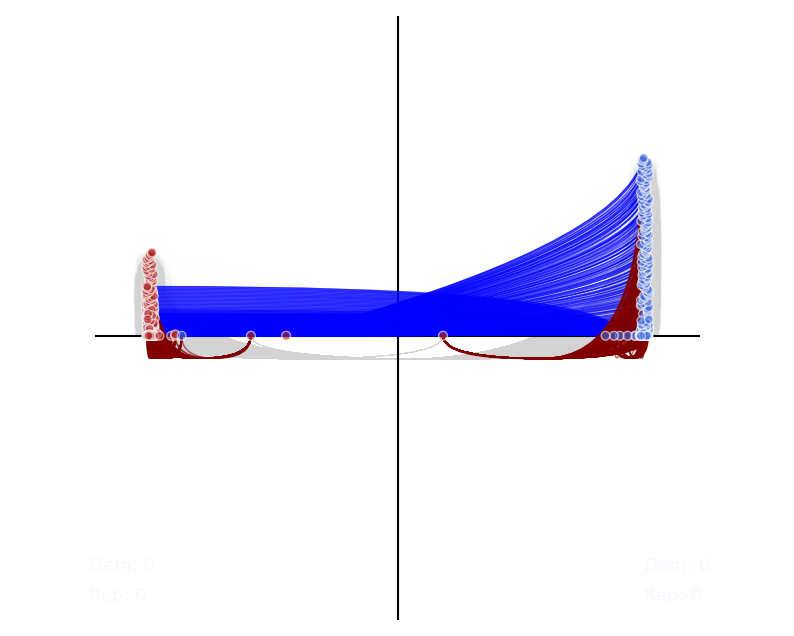

In [75]:
cong = '113'
temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/Civil_Liberties/'+cong+'_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/Civil_Liberties/congress_'+cong+'.csv', threshold_pos, threshold_neg)

In [71]:
# for each icpsr, check positive x positions and party = "['Democrat]" and print bioname, party and x position
for icpsr in x_pos_dic.keys():
    if x_pos_dic[icpsr]['x'] > 0 and 'Democrat' in str(x_pos_dic[icpsr]['party']):
        print(x_pos_dic[icpsr]['bioname'], x_pos_dic[icpsr]['party'], x_pos_dic[icpsr]['x'])


NORTON, Eleanor Holmes ['Democrat'] 0.6368873772261899
BORDALLO, Madeleine ['Democrat'] 0.9431442520934732


In [77]:
# for each icpsr, check positive x positions and party = "['Democrat]" and print bioname, party and x position
for icpsr in x_pos_dic.keys():
    if x_pos_dic[icpsr]['x'] > 0 and 'Democrat' in str(x_pos_dic[icpsr]['party']):
        print(x_pos_dic[icpsr]['bioname'], x_pos_dic[icpsr]['party'], x_pos_dic[icpsr]['x'])


McINTYRE, Mike ['Democrat'] 1.0294388924850253


In [76]:
for icpsr in x_pos_dic.keys():
    if x_pos_dic[icpsr]['x'] < 0 and 'Republican' in str(x_pos_dic[icpsr]['party']):
        print(x_pos_dic[icpsr]['bioname'], x_pos_dic[icpsr]['party'], x_pos_dic[icpsr]['x'])

BROUN, Paul C., Jr. ['Republican'] -0.21694185329861343


In [72]:
for icpsr in x_pos_dic.keys():
    if x_pos_dic[icpsr]['x'] < 0 and 'Republican' in str(x_pos_dic[icpsr]['party']):
        print(x_pos_dic[icpsr]['bioname'], x_pos_dic[icpsr]['party'], x_pos_dic[icpsr]['x'])

DAVIS, Jo Ann ['Republican'] -0.5218792125292214
WITTMAN, Robert J. ['Republican'] -0.29581829775287527


_______________________